# Cython
Cython can be viewed as an extension of Python where variables and functions are annotated with extra information, in particular types. The resulting Cython source code will be compiled into optimized C or C++ code, and thereby yielding substantial speed-up of slow Python code. In other word, cython provides a way of writting Python with  comparable performance of C/C++.

## Start  Coding in Cython

Cython code must, unlike Python, be compiled. This happens in the following stages:

* The cython code in `.pyx` file will be translated to a `C` file.
* The `C` file will be compiled by a C compiler into a shared library, which will be directely loaded into Python. 

In ipython notebook, everything is a lot easier. One need only to load Cython extension (`%load_ext Cython`) at the beginning and put `%%cython` mark in front of cells of cython code. Cells with cython mark will be treated as a `.pyx` code and consequently, compiled into C. 

For details, please see [Building Cython Code](http://docs.cython.org/src/quickstart/build.html).


**Pure python Medelbrot set:**

In [1]:
xmin=-1.5
ymin=-1.0
xmax=0.5
ymax=1.0
resolution=300
xstep=(xmax-xmin)/resolution
ystep=(ymax-ymin)/resolution
xs=[(xmin+(xmax-xmin)*i/resolution) for i in range(resolution)]
ys=[(ymin+(ymax-ymin)*i/resolution) for i in range(resolution)]

In [2]:
def mandel(position,limit=50):
    value=position
    while abs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

**Compiled by Cython:**

In [3]:
%load_ext Cython 

In [4]:
%%cython
def mandel_cython(position,limit=50):
    value=position
    while abs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

Let's verify the result

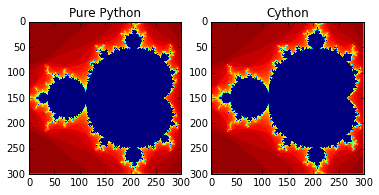

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
f, axarr = plt.subplots(1,2)
axarr[0].imshow([[mandel(complex(x,y)) for x in xs] for y in ys],interpolation='none')
axarr[0].set_title('Pure Python')
axarr[1].imshow([[mandel(complex(x,y)) for x in xs] for y in ys],interpolation='none')
axarr[1].set_title('Cython')

In [6]:
%timeit [[mandel(complex(x,y)) for x in xs] for y in ys] # pure python
%timeit [[mandel_cython(complex(x,y)) for x in xs] for y in ys] # cython

1 loops, best of 3: 482 ms per loop
1 loops, best of 3: 333 ms per loop


We have improved the performance of a factor of 1.5 by just using the cython compiler, **without changing the code**!

## Cython with C Types
But we can do better by telling Cython what C data type we would use in the code. Note we're not actually writing C, we're writing Python with C types.

_typed variable_

In [7]:
%%cython
def var_typed_mandel_cython(position,limit=50):
    cdef double complex value # typed variable
    value=position
    while abs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

_typed function + typed variable_

In [8]:
%%cython
cpdef call_typed_mandel_cython(double complex position,int limit=50): # typed function
    cdef double complex value # typed variable
    value=position
    while abs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

performance of one number:

In [9]:
%timeit a=mandel(complex(0,0)) # pure python
%timeit a=mandel_cython(complex(0,0)) # premitive cython
%timeit a=var_typed_mandel_cython(complex(0,0)) # cython with C type variable
%timeit a=call_typed_mandel_cython(complex(0,0)) # cython with typed variable + function

100000 loops, best of 3: 10.8 µs per loop
100000 loops, best of 3: 7.42 µs per loop
100000 loops, best of 3: 5.72 µs per loop
100000 loops, best of 3: 2.75 µs per loop


## Cython with numpy ndarray
You can use NumPy from Cython exactly the same as in regular Python, but by doing so you are losing potentially high speedups because Cython has support for fast access to NumPy arrays. 

In [10]:
import numpy as np
ymatrix,xmatrix=np.mgrid[ymin:ymax:ystep,xmin:xmax:xstep]
values=xmatrix+1j*ymatrix

In [11]:
%%cython
import numpy as np
cimport numpy as np 

cpdef numpy_cython_1(np.ndarray[double complex,ndim=2] position, int limit=50): 
    cdef np.ndarray[long,ndim=2] diverged_at
    cdef double complex value
    cdef int xlim
    cdef int ylim
    cdef double complex pos
    cdef int steps
    cdef int x, y

    xlim=position.shape[1]
    ylim=position.shape[0]
    diverged_at=np.zeros([ylim, xlim], dtype=int)
    for x in xrange(xlim):
        for y in xrange(ylim):
             steps=limit
             value=position[y,x]
             pos=position[y,x]
             while abs(value)<2 and steps>=0:
                steps-=1
                value=value**2+pos
             diverged_at[y,x]=steps
  
    return diverged_at

Note the double import of numpy: the standard numpy module and a Cython-enabled version of numpy that ensures fast indexing of and other operations on arrays. Both import statements are necessary in code that uses numpy arrays. The new thing in the code above is declaration of arrays by np.ndarray.

In [12]:
%timeit data_cy=[[mandel(complex(x,y)) for x in xs] for y in ys] # pure python
%timeit data_cy=[[call_typed_mandel_cython(complex(x,y)) for x in xs] for y in ys] # typed cython
%timeit numpy_cython_1(values) # ndarray

1 loops, best of 3: 501 ms per loop
10 loops, best of 3: 125 ms per loop
10 loops, best of 3: 118 ms per loop


**A trick of using `np.vectorize`**

In [13]:
numpy_cython_2=np.vectorize(call_typed_mandel_cython)

In [14]:
%timeit numpy_cython_2(values) #  vectorize

10 loops, best of 3: 108 ms per loop


## Calling C functions from Cython

**Example: compare `sin()` from Python and C library**

In [15]:
%%cython
import math
cpdef py_sin():
    cdef int x
    cdef double y
    for x in xrange(1e7):
        y=math.sin(x)

In [16]:
%%cython
from libc.math cimport sin as csin # import from C library
cpdef c_sin():
    cdef int x
    cdef double y
    for x in xrange(1e7):
        y=csin(x)

In [17]:
%timeit [math.sin(i) for i in xrange(int(1e7))] # python
%timeit py_sin()                                # cython call python library
%timeit c_sin()                                 # cython call C library

1 loops, best of 3: 1.3 s per loop
1 loops, best of 3: 817 ms per loop
100 loops, best of 3: 5.59 ms per loop
